Dataset & Dataloader con U-NET (para segmentacion de imagenes)

# Cuaderno en el que se crea una red neuronal tipo U-NET para analizar imágenes hechas por microscopio de células


# Imports

In [3]:
#instalamos para poder usar jupyterthemes
!pip install jupyterthemes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00


In [4]:
#Líneas con las que importamos los archivos de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Importar las librerías necesarias
# Carga de archivos desde Google Drive y Colab
from google.colab import files
from google.colab import drive

# Librerías para el modelo
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import random
import torch
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torch import nn, optim
from torch.nn import functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
# DataLoader y Dataset permiten usar conjuntos de datos ya existentes
# Dataset: guarda muestras y etiquetas
# DataLoader: crea un objeto iterable alrededor de un Dataset para un acceso conveniente

from jupyterthemes import jtplot
jtplot.style()  # Estilo visual para gráficos en Jupyter Notebook



# Rutas para las imágenes

In [6]:
#rutas para usar las imágenes
TRAIN_PATH ="/content/drive/MyDrive/train/img"
MASK_TRAIN_PATH="/content/drive/MyDrive/train/mask"
TEST_PATH="/content/drive/MyDrive/train/test"

# Visualización de imágenes con máscaras
Esto con el objetivo de poder comprobar el formato de las imágenes y de las máscaras, realizando las transformaciones necesarias con el objetivo de poder usarlas en el modelo (en el entrenamiento).

Este código recorre los archivos dentro de la carpeta en la ruta TRAIN_PATH y para cada imagen, abre la imagen correspondiente en la carpeta MASK_TRAIN_PATH, posteriormente convierte ambas imágenes en arreglos NumPy y muestra la información de los archivos. Todo con el objetivo de entender mejor la estructura de las imágenes y las máscaras utilizadas en el proyecto.

In [7]:
# Analizamos la estructura de las imágenes en las carpetas img y mask
for img in sorted(os.listdir(TRAIN_PATH)):
    with Image.open(os.path.join(TRAIN_PATH, img)) as pil_img, Image.open(os.path.join(MASK_TRAIN_PATH, img)) as pil_mask:
        np_img = np.asarray(pil_img)
        np_mask = np.asarray(pil_mask)
        print(f'Nombre del archivo: {img}')
        print(f'Forma de la imagen: {np_img.shape} Modo: {pil_img.mode}')
        print(f'Forma de la máscara: {np_mask.shape} Modo: {pil_mask.mode}')

Nombre del archivo: Ganglioneuroblastoma_0.tif
Forma de la imagen: (914, 1225, 3) Modo: RGB
Forma de la máscara: (914, 1225) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_1.tif
Forma de la imagen: (914, 1225, 3) Modo: RGB
Forma de la máscara: (914, 1225) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_10.tif
Forma de la imagen: (1024, 1360) Modo: L
Forma de la máscara: (1024, 1360) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_2.tif
Forma de la imagen: (914, 1225, 3) Modo: RGB
Forma de la máscara: (914, 1225) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_3.tif
Forma de la imagen: (914, 1225, 3) Modo: RGB
Forma de la máscara: (914, 1225) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_4.tif
Forma de la imagen: (914, 1225, 3) Modo: RGB
Forma de la máscara: (914, 1225) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_6.tif
Forma de la imagen: (1024, 1360) Modo: L
Forma de la máscara: (1024, 1360) Modo: I;16
Nombre del archivo: Ganglioneuroblastoma_7.tif
Forma 

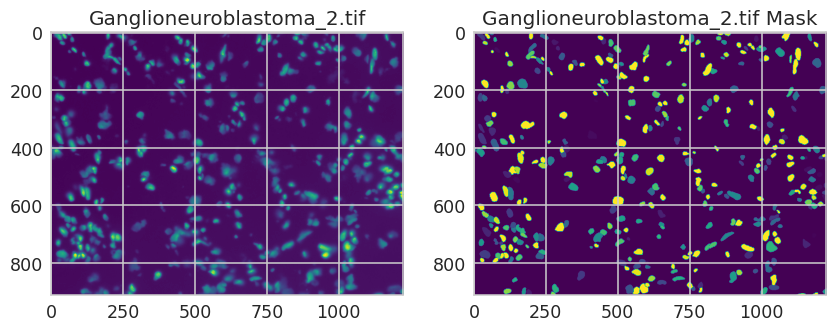

In [8]:
# Visualizamos img y mask
img_name = 'Ganglioneuroblastoma_2.tif'
with Image.open(os.path.join(TRAIN_PATH, img_name)) as img, Image.open(os.path.join(MASK_TRAIN_PATH, img_name)) as mask:
  img_L = img.convert('L')
  mask_L = mask.convert('L')

  np_img = np.asarray(img_L)
  np_mask = np.asarray(mask_L)

  fig = plt.figure(figsize=(10,7))

  fig.add_subplot(1, 2, 1)
  plt.imshow(np_img)
  plt.title(img_name)

  fig.add_subplot(1, 2, 2)
  plt.imshow(np_mask)
  plt.title(f'{img_name} Mask')


Este código transforma las máscaras multiclase en máscaras binarias, útil para el modelo que estamos desarrollando, ya que sólo diferencia "células" de ¨no células¨

In [9]:
def mask_transform_multiclass_to_binary(mask):
    with mask as mask_image:
        # Cambiar el tamaño de la imagen de la máscara a [224, 224]
        mask_image_resized = mask_image.resize((224, 224), Image.BILINEAR)

        mask_np = np.asarray(mask_image_resized)

        # Aplicar una función para transformar valores multiclase en binarios
        condition = np.vectorize(lambda x: 1 if x >= 1 else 0)
        mask_np = condition(mask_np)

        # Convertir la máscara NumPy a tensor utilizando la transformación ToTensor()
        return T.ToTensor()(mask_np)



# Creación el dataset para entrenamiento y validación

Listamos los elementos del directorio para comprobar que la ruta esté correcta

In [10]:
os.listdir(TRAIN_PATH)


['normal_3.tif',
 'normal_6.tif',
 'normal_1.tif',
 'normal_10.tif',
 'normal_2.tif',
 'normal_0.tif',
 'normal_4.tif',
 'normal_5.tif',
 'normal_9.tif',
 'normal_7.tif',
 'normal_8.tif',
 'normal_29.tif',
 'normal_31.tif',
 'normal_23.tif',
 'normal_12.tif',
 'normal_28.tif',
 'normal_30.tif',
 'normal_18.tif',
 'normal_24.tif',
 'normal_15.tif',
 'normal_17.tif',
 'normal_25.tif',
 'normal_20.tif',
 'normal_16.tif',
 'normal_26.tif',
 'normal_14.tif',
 'normal_11.tif',
 'normal_19.tif',
 'normal_21.tif',
 'normal_22.tif',
 'normal_27.tif',
 'normal_13.tif',
 'Neuroblastoma_3.tif',
 'Neuroblastoma_6.tif',
 'Neuroblastoma_1.tif',
 'Neuroblastoma_2.tif',
 'Neuroblastoma_0.tif',
 'Neuroblastoma_8.tif',
 'Neuroblastoma_7.tif',
 'Neuroblastoma_5.tif',
 'Neuroblastoma_4.tif',
 'Neuroblastoma_9.tif',
 'Ganglioneuroblastoma_3.tif',
 'Ganglioneuroblastoma_1.tif',
 'Neuroblastoma_10.tif',
 'Ganglioneuroblastoma_0.tif',
 'Neuroblastoma_13.tif',
 'Ganglioneuroblastoma_2.tif',
 'Neuroblastoma_12.t

Esta clase nos sirve para crear un conjunto de datos personalizado para el entrenamiento y la validación del modelo

In [11]:
class Cell_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        # Inicializar las rutas de los datos y las máscaras, y las transformaciones de imágenes y máscaras
        self.train_data = data
        self.train_masks = masks
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Obtener la lista de nombres de archivos de imágenes
        self.images = sorted(os.listdir(self.train_data))

        # Si se proporcionaron máscaras, obtener la lista de nombres de archivos de máscaras
        self.masks = sorted(os.listdir(self.train_masks)) if self.train_masks is not None else None

    def __len__(self):
        if self.train_masks is not None:
            # Aseguramos que el número de imágenes coincida con el número de máscaras (si están disponibles)
            assert len(self.images) == len(self.masks), 'No hay el mismo número de imágenes y máscaras'
        return len(self.images)

    def __getitem__(self, idx):
        # Obtener el nombre de archivo de imagen en la posición del índice proporcionado
        image_name = os.path.join(self.train_data, self.images[idx])

        # Abrir y convertir la imagen a escala de grises
        img = Image.open(image_name).convert('L')

        # Aplicar transformaciones comunes a las imágenes (por ejemplo, redimensionar y convertir a tensor)
        transform = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = transform(img)

        if self.train_masks is not None:
            # Si hay máscaras disponibles, obtener el nombre de archivo de máscara correspondiente
            mask_name = os.path.join(self.train_masks, self.masks[idx])

            # Abrir y convertir la máscara a escala de grises
            mask = Image.open(mask_name).convert('L')

            # Aplicar transformaciones a las máscaras (por ejemplo, redimensionar y convertir a tensor)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = transform(mask)

            # Devolver la imagen y la máscara correspondiente
            return img, mask

        else:
            # Si no hay máscaras disponibles, devolver solo la imagen
            return img


Transformaciones sobre los datos a tensores y redimensión del tamaño

In [12]:
transform_data = T.Compose([T.Resize([224, 224]), T.ToTensor()])



Dataloaders

In [13]:
# Crear una instancia del conjunto de datos con transformaciones personalizadas
full_data = Cell_Dataset(TRAIN_PATH, MASK_TRAIN_PATH, img_transforms=transform_data, mask_transforms=mask_transform_multiclass_to_binary)
# Aquí creamos el conjunto de datos utilizando las rutas de los datos y las máscaras.
# También especificamos las transformaciones de imagen y máscara que se aplicarán a las muestras.

# Definir el tamaño del lote (batch size) para el entrenamiento
BATCH_SIZE = 10

# Calcular el tamaño de entrenamiento y validación en función del porcentaje
# Aquí estamos dividiendo el conjunto de datos en un 80% para entrenamiento y un 20% para validación.
# TRAIN_SIZE se utiliza para determinar cuántas muestras se utilizarán para el entrenamiento,
# y VALID_SIZE es el número restante de muestras que se utilizarán para la validación.
TRAIN_SIZE = int(len(full_data)) * 80
TRAIN_SIZE = int(TRAIN_SIZE/100)
VALID_SIZE = int(len(full_data)) - TRAIN_SIZE
# Si quisieras cambiar el porcentaje de entrenamiento y validación, solo ajusta el valor multiplicativo.

# Mostrar el tamaño final de entrenamiento y validación
print(f"Tamaño de entrenamiento: {TRAIN_SIZE} muestras")
print(f"Tamaño de validación: {VALID_SIZE} muestras")



Tamaño de entrenamiento: 55 muestras
Tamaño de validación: 14 muestras


In [14]:
#para separarlos con los numeros que hemos obtenido anteriormente
#nos devuelve el dataset de entrenamiento y de validación
train_dataset, val_dataset = random_split(full_data, [TRAIN_SIZE, VALID_SIZE])

Aquí estamos creando los cargadores de datos utilizando los conjuntos de datos de entrenamiento y validación.

Especificamos el tamaño del lote (batch size) y configuramos shuffle=True para mezclar los datos en cada época.

Esto nos ayudará a obtener diferentes muestras en cada lote durante el entrenamiento y la validación.

In [15]:
# Crear cargadores de datos para el entrenamiento y la validación
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


Los dataloaders permiten iterar a traves de los objetos

In [16]:
# Obtener un lote de imágenes y máscaras del cargador de entrenamiento
img, masks = next(iter(train_loader))
# Aquí estamos utilizando la función next() para obtener el siguiente lote de imágenes y máscaras del cargador de entrenamiento.
# Este lote se utiliza para alimentar al modelo durante el entrenamiento.

# Mostrar las formas de las imágenes y las máscaras en el lote
print("Forma de las imágenes en el lote:", img.shape)
print("Forma de las máscaras en el lote:", masks.shape)
# Aquí estamos imprimiendo las formas de las imágenes y las máscaras en el lote.
# Esto nos proporciona información sobre la cantidad de muestras en el lote y las dimensiones de cada muestra.


Forma de las imágenes en el lote: torch.Size([10, 1, 224, 224])
Forma de las máscaras en el lote: torch.Size([10, 1, 224, 224])


En este bucle, estamos iterando a través del cargador de entrenamiento utilizando la función enumerate() para obtener tanto el índice como el lote.

Luego, imprimimos el número de lote y las formas de las imágenes y las máscaras en ese lote.

Usamos un condicional para romper el ciclo después de mostrar las formas de los primeros 12 lotes (0 al 11).

Esto nos proporciona una idea de las dimensiones de las muestras en los primeros lotes del conjunto de entrenamiento.

In [17]:
# Iterar a través del cargador de entrenamiento y mostrar las formas de las muestras en los primeros 12 lotes
for i, (x, y) in enumerate(train_loader):
    print(f"Lote {i}:")
    print("Forma de las imágenes:", x.shape)
    print("Forma de las máscaras:", y.shape)

    # Romper el ciclo después de mostrar las formas de los primeros 12 lotes
    if i == 11:
        break


Lote 0:
Forma de las imágenes: torch.Size([10, 1, 224, 224])
Forma de las máscaras: torch.Size([10, 1, 224, 224])
Lote 1:
Forma de las imágenes: torch.Size([10, 1, 224, 224])
Forma de las máscaras: torch.Size([10, 1, 224, 224])
Lote 2:
Forma de las imágenes: torch.Size([10, 1, 224, 224])
Forma de las máscaras: torch.Size([10, 1, 224, 224])
Lote 3:
Forma de las imágenes: torch.Size([10, 1, 224, 224])
Forma de las máscaras: torch.Size([10, 1, 224, 224])
Lote 4:
Forma de las imágenes: torch.Size([10, 1, 224, 224])
Forma de las máscaras: torch.Size([10, 1, 224, 224])
Lote 5:
Forma de las imágenes: torch.Size([5, 1, 224, 224])
Forma de las máscaras: torch.Size([5, 1, 224, 224])


# Visualizar los datos

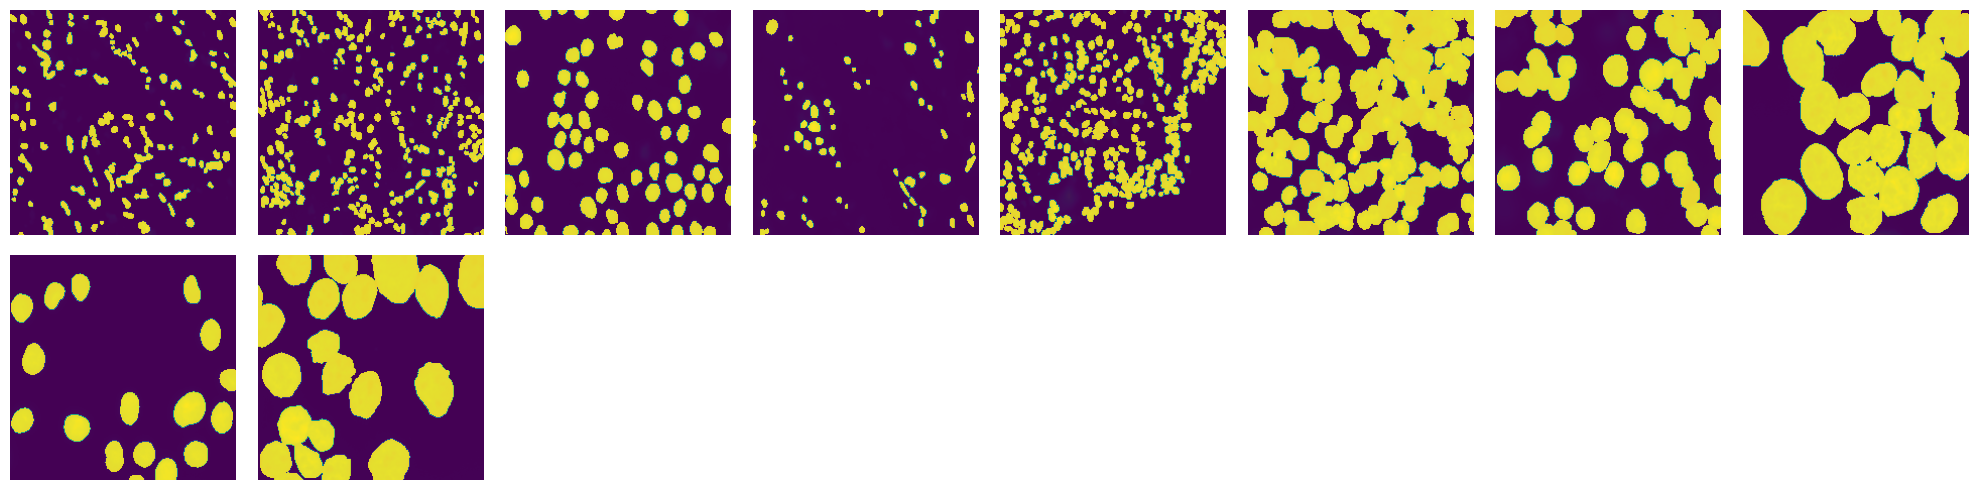

In [18]:
# Obtener el siguiente lote del cargador de entrenamiento
img, masks = next(iter(train_loader))

# Definir una función para trazar un mini lote de imágenes y máscaras
def plot_mini_batch(images, masks):
    # Crear una figura grande para mostrar las imágenes y las máscaras
    plt.figure(figsize=(20, 10))

    # Iterar a través del tamaño del lote
    for i in range(BATCH_SIZE):
        # Crear una subparcela en la figura para cada imagen y máscara
        plt.subplot(4, 8, i + 1)

        # Convertir las imágenes y las máscaras en matrices numpy y permutar los ejes para mostrarlas correctamente
        image = images[i, ...].permute(1, 2, 0).numpy()
        mask = masks[i, ...].permute(1, 2, 0).numpy()

        # Mostrar la imagen y superponer la máscara con un efecto de transparencia
        plt.imshow(image)
        plt.imshow(mask, alpha=0.9)

        # Desactivar ejes
        plt.axis('off')

    # Ajustar el diseño de las subparcelas y mostrar la figura
    plt.tight_layout()
    plt.show()

# Llamar a la función para trazar el mini lote actual
plot_mini_batch(img, masks)


# Creación de la U-NET

Estructura del modelo U-NET

In [19]:
import torch
from torch import nn

# Definición de la clase para un kernel de convolución de tamaño 3x3
class Conv_3Kernel(nn.Module):
    def __init__(self, input, output):
        super().__init__()  # Llamada al constructor de la clase padre

        # Definición de la capa de convolución con kernel de tamaño 3x3
        self.conv1 = nn.Conv2d(input, output, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv1(x)

#------------------------------------------------------------------------#

# Definición de la clase para una capa de convolución doble
class Double_Layer_Conv(nn.Module):
    def __init__(self, input, output):
        super().__init__()  # Llamada al constructor de la clase padre

        # Definición de la secuencia de capas de convolución doble
        self.double_conv = nn.Sequential(
            Conv_3Kernel(input, output),
            nn.BatchNorm2d(output),
            nn.ReLU(),

            Conv_3Kernel(output, output),
            nn.BatchNorm2d(output),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

#------------------------------------------------------------------------#

# Definición de la clase para la etapa de downsampling
class Down_Conv(nn.Module):
    def __init__(self, input, output):
        super().__init__()  # Llamada al constructor de la clase padre

        # Definición de la secuencia de capas de downsampling
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2, 2),  # Maxpooling con tamaño de 2x2 y stride de 2
            Double_Layer_Conv(input, output)
        )

    def forward(self, x):
        return self.encoder(x)

#------------------------------------------------------------------------#

# Definición de la clase para la etapa de upsampling
class Up_Conv(nn.Module):
    def __init__(self, input, output):
        super().__init__()  # Llamada al constructor de la clase padre

        # Definición de la secuencia de capas de upsampling
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic'),  # Upsampling con factor de escala 2 y modo bicubic
            nn.Conv2d(input, int(input / 2), kernel_size=1, stride=1)
        )

        # Definición de la capa de decodificación doble
        self.decoder = Double_Layer_Conv(input, output)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)  # Upsampling de x1
        x = torch.cat([x2, x1], dim=1)  # Concatenación de x2 y x1
        return self.decoder(x)

#------------------------------------------------------------------------#

# Definición de la clase para la red U-Net completa
class U_NET(nn.Module):
    def __init__(self, input, canales, num_classes):
        super().__init__()  # Llamada al constructor de la clase padre

        # Definición de las capas de convolución y upsampling
        self.first_conv = Double_Layer_Conv(input, canales)

        self.down1 = Down_Conv(canales, 2 * canales)
        self.down2 = Down_Conv(2 * canales, 4 * canales)
        self.down3 = Down_Conv(4 * canales, 8 * canales)
        self.down4 = Down_Conv(8 * canales, 16 * canales)

        self.up1 = Up_Conv(16 * canales, 8 * canales)
        self.up2 = Up_Conv(8 * canales, 4 * canales)
        self.up3 = Up_Conv(4 * canales, 2 * canales)
        self.up4 = Up_Conv(2 * canales, canales)

        # Capa de convolución final 1x1
        self.last = nn.Conv2d(canales, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        # Pasos de la arquitectura U-Net
        d1 = self.first_conv(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)

        d5 = self.down4(d4) #middle convolution

        up6 = self.up1(d5, d4)
        up7 = self.up2(up6, d3)
        up8 = self.up3(up7, d2)
        up9 = self.up4(up8, d1)

        salida = self.last(up9)

        return salida




# Prueba -
Se puede ignorar, no influye en el funcionamiento solo realiza una prueba y saca la estructura del modelo por pantalla, descomentar si se necesita

In [20]:
"""!pip install torchviz
!apt-get install -y graphviz
!pip install tensorboardX"""

'!pip install torchviz\n!apt-get install -y graphviz\n!pip install tensorboardX'

In [21]:
"""import torch
import torch.nn as nn
from torchviz import make_dot
import graphviz"""

'import torch\nimport torch.nn as nn\nfrom torchviz import make_dot\nimport graphviz'

In [22]:
"""def test():
  #funcion que nos permite comprobar que las dim son las esperadas
  x = torch.randn((32, 3, 224, 224), dtype= torch.float32) #mandamos tensor que corresponda a las dim de un mini batch
  model = U_NET(3, 64, 2)
  #3 canal de entrada, 2 clase, 64
  return model(x)

preds = test()"""



'def test():\n  #funcion que nos permite comprobar que las dim son las esperadas\n  x = torch.randn((32, 3, 224, 224), dtype= torch.float32) #mandamos tensor que corresponda a las dim de un mini batch\n  model = U_NET(3, 64, 2)\n  #3 canal de entrada, 2 clase, 64\n  return model(x)\n\npreds = test()'

In [23]:
"""import torch
import torch.nn as nn
from torchsummary import summary
from tensorboardX import SummaryWriter

# Create an instance of your model
model_instance = U_NET(3, 64, 2)

# Choose a device (CPU or GPU) for model evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_instance.to(device)

# Display the model summary in the Colab notebook
summary(model_instance, input_size=(3, 224, 224))

# Generate the computation graph for the model instance
x = torch.randn((1, 3, 224, 224), dtype=torch.float32).to(device)
output = model_instance(x)

# Save the computation graph to TensorBoard format
with SummaryWriter(log_dir='./logs', comment='U_NET') as writer:
    writer.add_graph(model_instance, x)"""

'import torch\nimport torch.nn as nn\nfrom torchsummary import summary\nfrom tensorboardX import SummaryWriter\n\n# Create an instance of your model\nmodel_instance = U_NET(3, 64, 2)\n\n# Choose a device (CPU or GPU) for model evaluation\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel_instance.to(device)\n\n# Display the model summary in the Colab notebook\nsummary(model_instance, input_size=(3, 224, 224))\n\n# Generate the computation graph for the model instance\nx = torch.randn((1, 3, 224, 224), dtype=torch.float32).to(device)\noutput = model_instance(x)\n\n# Save the computation graph to TensorBoard format\nwith SummaryWriter(log_dir=\'./logs\', comment=\'U_NET\') as writer:\n    writer.add_graph(model_instance, x)'

In [24]:
#%load_ext tensorboard
#%tensorboard --logdir=./logs

In [25]:
#print(preds.shape)


# Funciones para entrenamiento del modelo

Funciones accuracy (precisión del modelo) y train (entrenamiento del modelo)

In [26]:
import torch
import torch.nn.functional as F
from matplotlib.offsetbox import mbbox_artist

# Verificar si hay disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def accuracy(model, loader):
    # Función para calcular la precisión del modelo utilizando el conjunto de datos del DataLoader
    # model: el modelo a evaluar
    # loader: un DataLoader que proporciona los datos para evaluar el modelo
    # Devuelve la pérdida promedio, precisión, coeficiente Dice e Índice de Jaccard

    correct = 0
    intersection = 0
    den = 0
    union = 0
    total = 0
    cost = 0

    # Mover el modelo a la GPU si está disponible
    model = model.to(device=device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)

            # Mostrar dimensiones de la entrada y el objetivo
            print("Input shape:", x.shape)
            print("Target shape:", y.shape)

            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()

            # Calcular predicciones y precisión
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)

            # Calcular coeficiente Dice e Índice de Jaccard
            intersection += (torch.sum(scores.argmax(dim=1) == y))
            den += (torch.numel(scores) + torch.numel(y))
            union += (torch.sum(scores.argmax(dim=1) == y) + torch.numel(y))

            dice = 2 * intersection / (den + 1e-8)
            iou = intersection / (union + 1e-8)


    # Calcular y devolver la pérdida promedio, precisión, coeficiente Dice e IoU
    avg_loss = cost / len(loader)
    accuracy = float(correct) / total
    return avg_loss, accuracy, dice, iou


#------------------------------------------------------------------------------------


def train(model, optimizer, scheduler=None, epochs=100, store_every=20):
    """
    Función para entrenar el modelo.

    Parámetros:
        model: El modelo a entrenar.
        optimizer: El optimizador a utilizar para ajustar los pesos del modelo.
        scheduler: El programador de velocidad de aprendizaje (opcional).
        epochs: Número de épocas de entrenamiento.
        store_every: Cada cuántos minibatches almacenar resultados y mostrar información.
    """

    model = model.to(device=device)

    # Ciclo de entrenamiento a través de las épocas
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0

        # Ciclo de entrenamiento a través de los minibatches
        for minibatch, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)

            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Si se proporciona un scheduler, ajusta la tasa de aprendizaje
            if scheduler:
                scheduler.step()

            train_predict = torch.argmax(scores, dim=1)
            train_correct_num += (train_predict == y).sum()
            train_total += torch.numel(train_predict)
            train_cost_acum = cost.item()

            # Almacenar y mostrar resultados periódicamente
            if minibatch % store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num) / train_total
                train_cost_every = float(train_cost_acum) / minibatch

                print("Época: " + str(epoch + 1) +
                      " minibatch: " + str(minibatch) +
                      " costo entrenamiento: " + str(train_cost_every) +
                      " costo validación: " + str(val_cost) +
                      " precisión entrenamiento: " + str(train_acc) +
                      " precisión validación: " + str(val_acc) +
                      " coeficiente Dice: " + str(dice) +
                      " Índice de Jaccard: " + str(iou))

        # Calcula y devuelve la precisión de entrenamiento y otros resultados si es necesario



### Learning rate

In [27]:
def find_learning_rate(model, optimizer, start_lr, end_lr, beta, loader):
    """
    Encuentra la tasa de aprendizaje óptima utilizando el método de búsqueda de tasa de aprendizaje.

    Parámetros:
        model: El modelo a evaluar.
        optimizer: El optimizador a utilizar.
        start_lr: Tasa de aprendizaje inicial para la búsqueda.
        end_lr: Tasa de aprendizaje final para la búsqueda.
        beta: Factor de decaimiento exponencial.
        loader: DataLoader que proporciona los datos de entrenamiento.

    Devuelve:
        log_lrs: Lista de tasas de aprendizaje utilizadas durante la búsqueda.
        loss_2: Lista de pérdidas promedio correspondientes a cada tasa de aprendizaje.
        accuracies: Lista de precisión correspondiente a cada tasa de aprendizaje.
    """
    num_batches = len(loader)
    factor = (end_lr / start_lr) ** (1 / (num_batches - 1))
    learning_rate = start_lr
    optimizer.param_groups[0]['lr'] = learning_rate

    avg_loss, current_loss, accuracy = 0., 0., 0.
    lowest_loss = float('inf')
    batch_num = 0

    loss_2 = []
    log_lrs = []
    accuracies = []

    # Mueve el modelo al dispositivo adecuado (CPU o GPU)
    model = model.to(device=device)

    for batch_idx, (inputs, targets) in enumerate(loader, start=1):
        # Mueve las entradas y objetivos al dispositivo y tipo de datos apropiados
        inputs = inputs.to(device=device, dtype=torch.float32)
        targets = targets.to(device=device, dtype=torch.long).squeeze(1)

        optimizer.zero_grad()
        scores = model(inputs)
        cost = F.cross_entropy(input=scores, target=targets)

        # Promedio móvil ponderado exponencialmente de la pérdida
        current_loss = beta * current_loss + (1 - beta) * cost.item()
        avg_loss = current_loss / (1 - beta**batch_idx)

        preds = torch.argmax(scores, dim=1)
        accuracy = (preds == targets).sum().item() / torch.numel(scores)

        # Si la pérdida promedio aumenta abruptamente, terminar la búsqueda
        if batch_idx > 1 and avg_loss > 4 * lowest_loss:
            print("Pérdida aumentó significativamente en el lote " + str(batch_idx) + ", " + str(cost.item()))
            return log_lrs, loss_2, accuracies

        # Actualizar la pérdida mínima
        if avg_loss < lowest_loss or batch_idx == 1:
            lowest_loss = avg_loss

        # Almacenar métricas en listas
        accuracies.append(accuracy)
        loss_2.append(avg_loss)
        log_lrs.append(learning_rate)

        # Retropropagación y actualización de parámetros
        cost.backward()
        optimizer.step()

        # Imprimir información del proceso
        print("Pérdida: " + str(cost.item()) + ", Tasa de Aprendizaje: " + str(learning_rate))

        # Actualizar la tasa de aprendizaje para el siguiente lote
        learning_rate *= factor
        optimizer.param_groups[0]['lr'] = learning_rate

    return log_lrs, loss_2, accuracies


# Entrenamiento

In [28]:
# Establecer la semilla para la reproducibilidad de los resultados
torch.manual_seed(42)

# Crear una instancia del modelo U-Net
# Parámetros: (input, canales, num_classes)
# input: número de canales de entrada
# canales: canal base (por ejemplo, 4, múltiplo de 64)
# num_classes: número de canales de salida
model = U_NET(1, 4, 2)

# Crear un optimizador SGD (Stochastic Gradient Descent) para el modelo U-Net
# Parámetros: (parámetros del modelo, lr, momentum, weight_decay)
# lr: tasa de aprendizaje inicial
# momentum: factor de inercia para el descenso de gradiente
# weight_decay: factor de regularización L2
optimizer_u_net = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.96, weight_decay=1e-4)

# Encontrar la tasa de aprendizaje óptima utilizando la función find_learning_rate
# Parámetros: (modelo, optimizador, start_lr, end_lr, beta, loader)
# start_lr: tasa de aprendizaje inicial para la búsqueda
# end_lr: tasa de aprendizaje final para la búsqueda
# beta: valor beta para el decaimiento exponencial
# loader: data loader para la evaluación del modelo
lg_lr, losses, accuracies = find_learning_rate(model, optimizer_u_net, start_lr=1e-6, end_lr=10, beta=0.99, loader=train_loader)


Pérdida: 0.7207108736038208, Tasa de Aprendizaje: 1e-06
Pérdida: 0.7270826697349548, Tasa de Aprendizaje: 2.5118864315095805e-05
Pérdida: 0.7434734106063843, Tasa de Aprendizaje: 0.0006309573444801934
Pérdida: 0.7526516914367676, Tasa de Aprendizaje: 0.01584893192461114
Pérdida: 0.5928933024406433, Tasa de Aprendizaje: 0.3981071705534975
Pérdida: 0.6095319390296936, Tasa de Aprendizaje: 10.000000000000007


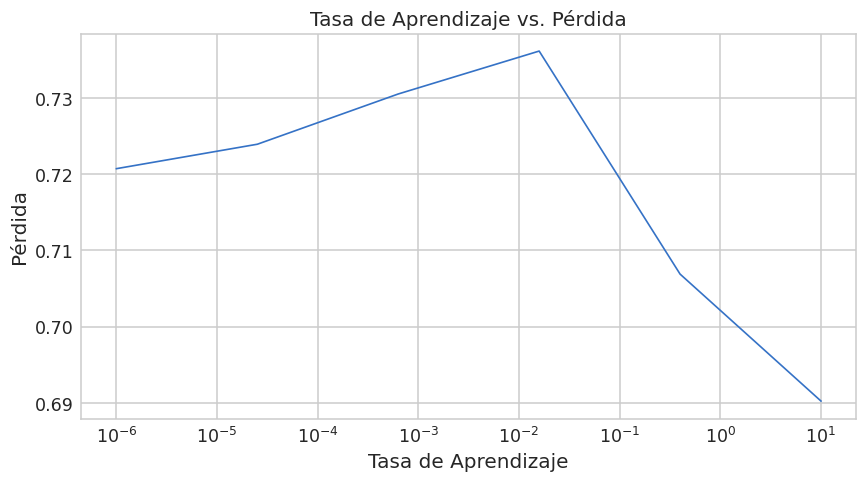

In [29]:
import matplotlib.pyplot as plt

def plot_learning_rate_vs_loss(learning_rates, losses):
    """
    Grafica la pérdida en función de la tasa de aprendizaje.

    Parámetros:
        learning_rates (lista): Lista de tasas de aprendizaje.
        losses (lista): Lista de valores de pérdida correspondientes.
    """
    # Crear una nueva figura y un eje para el trazado
    fig, ax = plt.subplots(figsize=(10, 5))

    # Graficar la tasa de aprendizaje vs. pérdida
    ax.plot(learning_rates, losses)

    # Establecer el eje x para que se muestre en escala logarítmica
    ax.set_xscale('log')

    # Establecer etiquetas de los ejes y título del gráfico
    ax.set_xlabel('Tasa de Aprendizaje')
    ax.set_ylabel('Pérdida')
    ax.set_title('Tasa de Aprendizaje vs. Pérdida')

    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso:
# lg_lr es la lista de tasas de aprendizaje y losses es la lista correspondiente de valores de pérdida
plot_learning_rate_vs_loss(lg_lr, losses)



In [30]:
# Establecer la semilla aleatoria para reproducibilidad
torch.manual_seed(42)

# Crear una instancia del modelo U-Net con 1 canal de entrada, 4 canales base y 2 canales de salida
model = U_NET(1, 4, 2)

# Definir el número de épocas para el entrenamiento
epochs = 10

# Crear un optimizador SGD (Descenso de Gradiente Estocástico) con parámetros de configuración
optimizer_u_net = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.96, weight_decay=1e-4)

# Crear un programador de velocidad de aprendizaje OneCycleLR
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_u_net,
                                                max_lr=1e-2,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs,
                                                pct_start=0.43,
                                                div_factor=10,
                                                final_div_factor=1000,
                                                three_phase=True)

# Entrenar el modelo utilizando la función train con el optimizador y el programador de velocidad de aprendizaje
train(model, optimizer_u_net, scheduler, epochs)


In [31]:
# Calcular las métricas de validación utilizando la función accuracy
val_cost, val_acc, dice, iou = accuracy(model, val_loader)

# Imprimir la precisión de validación
print("Validation Accuracy:", val_acc)


Input shape: torch.Size([10, 1, 224, 224])
Target shape: torch.Size([10, 224, 224])
Input shape: torch.Size([4, 1, 224, 224])
Target shape: torch.Size([4, 224, 224])
Validation Accuracy: 0.9381277901785714


# Prueba sobre imágenes

imagenes del set de pruebas

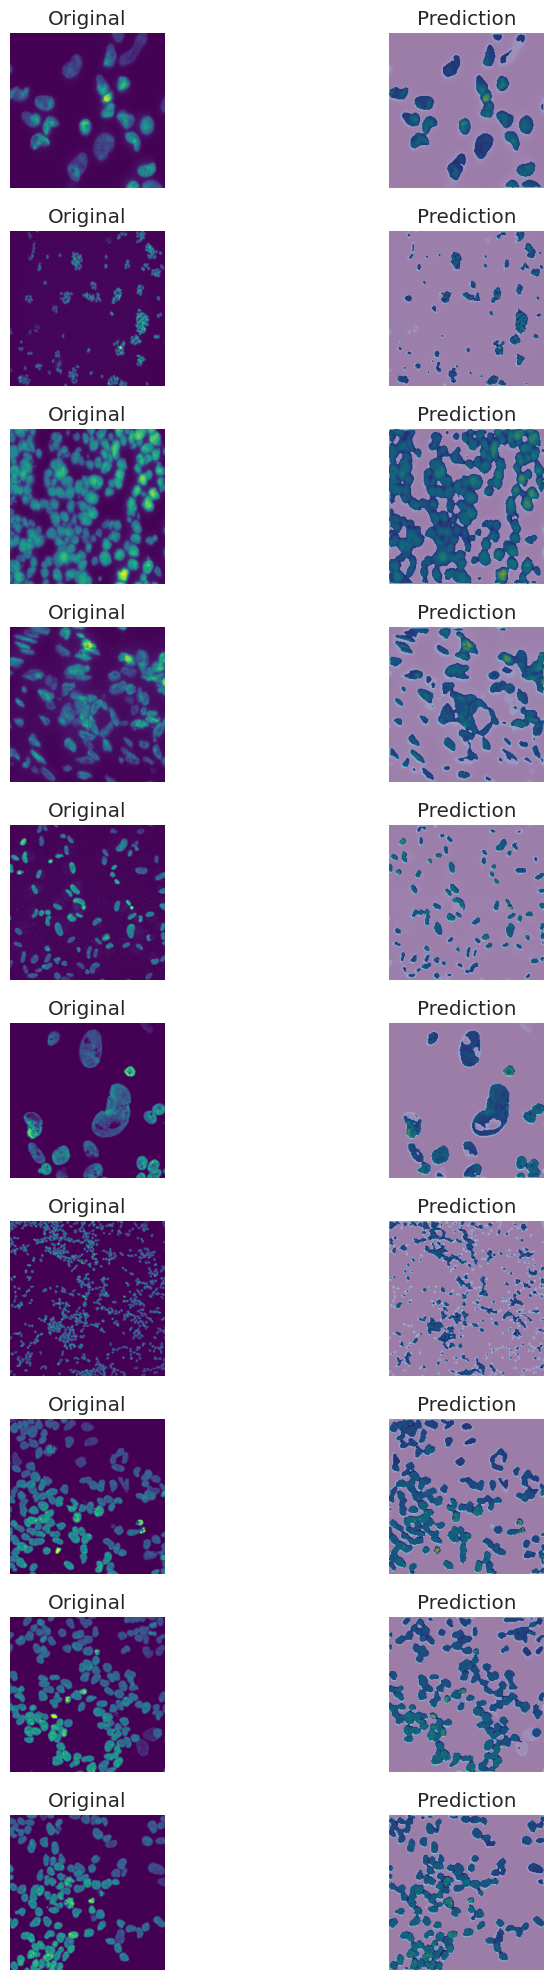

In [32]:
import matplotlib.pyplot as plt

def plot_mini_batch(images, masks, alpha=0.5):
    """
    Grafica un lote de imágenes y sus máscaras correspondientes.

    Parámetros:
        images (Tensor): Lote de imágenes de entrada.
        masks (Tensor): Lote de máscaras correspondientes.
        alpha (float, opcional): Valor de transparencia para la superposición de la máscara. El valor predeterminado es 0.5.
    """
    # Crear una figura y ejes para el gráfico
    fig, axes = plt.subplots(nrows=images.size(0), ncols=2, figsize=(10, 20))

    for i in range(images.size(0)):
        img = images[i].permute(1, 2, 0)  # Convertir tensor de imagen a (H, W, C)
        mask = masks[i].squeeze().cpu().numpy()

        # Mostrar la imagen original en la primera columna de ejes
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original')
        axes[i, 0].axis('off')

        # Mostrar la máscara como una superposición roja en la imagen en la segunda columna de ejes
        axes[i, 1].imshow(img)
        axes[i, 1].imshow(mask, cmap='Blues', alpha=alpha)
        axes[i, 1].set_title(f'Prediction')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Crear el conjunto de prueba y el dataloader correspondiente
test_set = Cell_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

# Obtener un lote de imágenes de prueba
images_test = next(iter(test_loader))
images_test = images_test.to(device, dtype=torch.float32)

# Mover el modelo a la misma dispositivo (GPU o CPU) que las imágenes
model = model.to(device)

# Calcular las predicciones del modelo para las imágenes de prueba
with torch.no_grad():
    scores = model(images_test)
    preds = torch.argmax(scores, dim=1).float()

# Mover las imágenes y las predicciones de nuevo a la CPU para visualización
images_test = images_test.cpu()
preds = preds.cpu()

# Llamar a la función de trazado para visualizar las imágenes y máscaras
plot_mini_batch(images_test, preds.unsqueeze(1))



# Guardamos el modelo

In [33]:
ruta_guardado = '/content/drive/MyDrive/train/model.pth'

# Cambia al modo de evaluación
model.eval()

"""
El modo de evaluación en PyTorch implica realizar ciertos cambios en el
comportamiento de ciertas capas, como las de normalización o las de dropout.
Esto asegura que el modelo no realice operaciones de entrenamiento durante la inferencia.
"""

# Guarda los parámetros del modelo en el archivo especificado
torch.save(model.state_dict(), ruta_guardado)

